# Tennis player gender classification using transfer learning
This notebook will attempt to classify male and female tennis players using images downloaded from Google image search. Each image has been labeled manually. 
We are going to try Google LeNet and Inception V3 networks to see how well they work for this problem.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle


Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.3.0


In [3]:
def image_to_input(model, preprocess_input_fn, img_path):
    target_size=model.input_shape[1:]
    img = keras_preprocessing_image.load_img(img_path, target_size=target_size)
    
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    return x

In [6]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [5]:
from scipy.misc import imread

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False)

In [150]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [500]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(.5)(x)
x = Dense(64, activation='relu')(x)
#x = Dropout(.5)(x)
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

In [501]:
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

In [502]:
for layer in model.layers[-15:]:
    print(layer.name,layer.trainable)

activation_89 False
activation_92 False
activation_93 False
batch_normalization_94 False
activation_86 False
mixed9_1 False
concatenate_2 False
activation_94 False
mixed10 False
global_average_pooling2d_6 True
dense_19 True
dropout_6 True
dense_20 True
dense_21 True
dense_22 True


In [503]:
#opt = keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])
BATCH_SIZE = 10
EPOCHS = 10

In [504]:
def get_batches( path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
    return gen.flow_from_directory(path, target_size=(299,299),
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [505]:
batches = get_batches('./data/images/train'
                          , gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
                          , batch_size = BATCH_SIZE)
val_batches = get_batches('./data/images/test'
                          , gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
                          , batch_size = BATCH_SIZE)

Found 467 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [506]:
hist = model.fit_generator(batches, steps_per_epoch=(467//BATCH_SIZE), epochs=EPOCHS,verbose=1,
                validation_data=val_batches, validation_steps=(30//BATCH_SIZE))

Epoch 1/10
46/46 [==============================] - 207s - loss: 0.7902 - acc: 0.5043 - val_loss: 0.6422 - val_acc: 0.8000
Epoch 2/10
46/46 [==============================] - 204s - loss: 0.6717 - acc: 0.5950 - val_loss: 0.7018 - val_acc: 0.5000
Epoch 3/10
46/46 [==============================] - 203s - loss: 0.5738 - acc: 0.6873 - val_loss: 0.5797 - val_acc: 0.6667
Epoch 4/10
46/46 [==============================] - 203s - loss: 0.5968 - acc: 0.7168 - val_loss: 0.6437 - val_acc: 0.5000
Epoch 5/10
46/46 [==============================] - 202s - loss: 0.6170 - acc: 0.6646 - val_loss: 0.5184 - val_acc: 0.7667
Epoch 6/10
46/46 [==============================] - 202s - loss: 0.4525 - acc: 0.8007 - val_loss: 0.6613 - val_acc: 0.6333
Epoch 7/10
46/46 [==============================] - 202s - loss: 0.5052 - acc: 0.7556 - val_loss: 0.6073 - val_acc: 0.7000
Epoch 8/10
46/46 [==============================] - 206s - loss: 0.4776 - acc: 0.7538 - val_loss: 0.4933 - val_acc: 0.7667
Epoch 9/10
46/46

In [487]:
metrics = model.evaluate_generator(val_batches,10,10,workers=1,pickle_safe=False)
print("model accuracy:",metrics[1])

/Users/adarsh/anaconda/envs/tfkeras/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras.pre..., 10, 10, workers=1, use_multiprocessing=False)`
  if __name__ == '__main__':


model accuracy: 0.70000000596


In [507]:
model.save('./dropout_model_small_128_64_32.h5')

In [4]:
model = keras.models.load_model('./dropout_model_small_128_64_32.h5')

Actual Class: male , Pred class: female , Scores: [[ 0.68002099  0.31997898]]


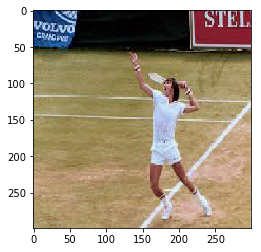

Actual Class: female , Pred class: male , Scores: [[ 0.47705853  0.52294147]]


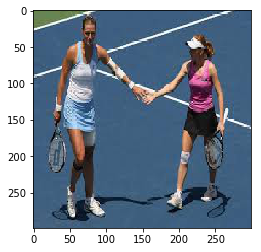

Actual Class: female , Pred class: male , Scores: [[ 0.30820844  0.69179159]]


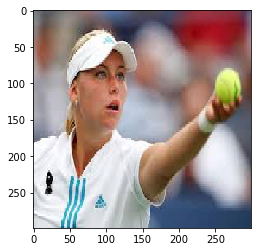

Actual Class: female , Pred class: male , Scores: [[ 0.43924347  0.5607565 ]]


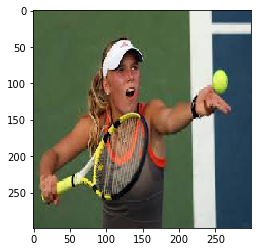

Actual Class: female , Pred class: male , Scores: [[ 0.39933819  0.60066181]]


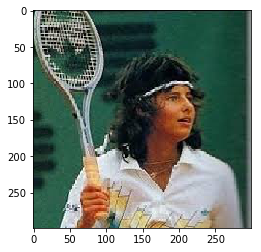

Actual Class: female , Pred class: male , Scores: [[ 0.39367983  0.60632014]]


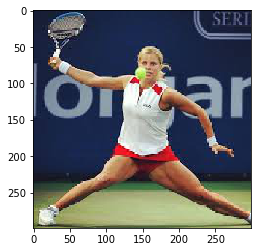

In [7]:
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from matplotlib.pyplot import imshow

import numpy as np
import glob
folder = './data/images/test/'
for gender in ['male','female']:
    for img_path in glob.glob(folder + gender +'/*.jpg')[:30]:
        #img_path = os.path.join('./data/images/test/', '/pic_153.jpg')
        img = image.load_img(img_path, target_size=(299,299,3))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        #print('Input image shape:', x.shape)

        preds = model.predict(x)
        pred_class = 'female' if preds.argmax()==0 else 'male'
        if gender != pred_class:
            print('Actual Class: %s , Pred class: %s , Scores: %s' % (gender,pred_class, str(preds)))
            plt.imshow(img)
            plt.show()

In [8]:
def reverse_preprocessing(x):
    x_reversed = x/2.
    x_reversed += 0.5
    x_reversed *= 255.
    print (x_reversed.shape)
    return x_reversed.astype(np.uint8)

In [12]:
def gen_nparray_fromdict(mydict, l, b):
    final_res = []
    for i in range(l):
        mid_res = []
        for j in range(b):
            mid_res.append(mydict[(i,j)])
        final_res.append(mid_res)
    return np.asarray(final_res)

def occuluding_img(model, img, window_size = (40,40), slide_size = 3, correct_class=0):
    # correct_class should be either 0 or 1, to indicate women or men respectively
    img_length = img.shape[0]
    img_width = img.shape[1]
    img_channels = img.shape[2]
    
    horizontal_runs = img_width// window_size[0]
    vertical_runs = img_length// window_size[1]
    res = {}
    
    #original image prediction
    expected_class = 'female' if correct_class ==0 else 'male'
    preds = model.predict(img.reshape(1, img.shape[0], img.shape[1], img.shape[2]))
    print ('expected_class: %s, predicts: %s' % (expected_class, str(preds)))
    
    #occuluding
    for h in range(horizontal_runs):
        for v in range(vertical_runs):
            tmp = img.copy()
            tmp[h*window_size[0]:(h+1)*window_size[0], v*window_size[1]:(v+1)*window_size[1]] = 0
            tmp = tmp.reshape(1,tmp.shape[0],tmp.shape[1], tmp.shape[2])
            preds = model.predict(tmp)
            correct_class_prob = preds[0][correct_class]
            res[(h,v)] = correct_class_prob

    res = gen_nparray_fromdict(res, horizontal_runs, vertical_runs)
    #print(res.shape)
    plt.imshow(res,cmap = 'hot')
    plt.colorbar()
    plt.show()
    return res

def load_img_and_occuluding(model, path, window_size = (40,40), slide_size = 3, correct_class = 0):
    img = image.load_img(path, target_size=(299,299,3))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    plt.imshow(reverse_preprocessing(x))
    plt.show()
    res = occuluding_img(model, x, window_size, slide_size, correct_class)
    return res 
            
    

(299, 299, 3)


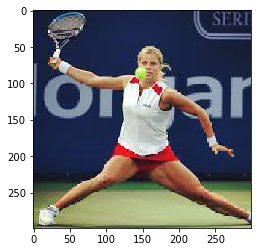

expected_class: female, predicts: [[ 0.39367983  0.60632014]]


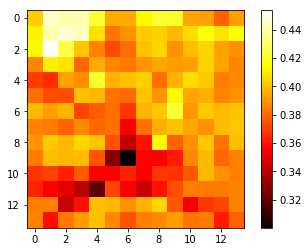

In [10]:
res= load_img_and_occuluding(model, './data/images/test/female/pic_161.jpg' , window_size=(20,20), correct_class=0)

(299, 299, 3)


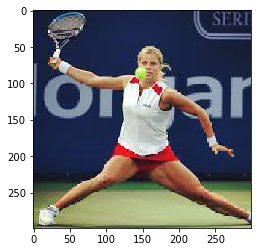

In [11]:
path = './data/images/test/female/pic_161.jpg'
img = image.load_img(path, target_size=(299,299,3))
x = image.img_to_array(img)
x = preprocess_input(x)
plt.imshow(reverse_preprocessing(x))
plt.show()

In [15]:
img = x
img_length = img.shape[0]
img_width = img.shape[1]
img_channels = img.shape[2]
window_size = (20,20)
correct_class = 0
horizontal_runs = img_width// window_size[0]
vertical_runs = img_length// window_size[1]
res = {}
    
#original image prediction
expected_class = 'female' if correct_class ==0 else 'male'
preds = model.predict(img.reshape(1, img.shape[0], img.shape[1], img.shape[2]))
print ('expected_class: %s, predicts: %s' % (expected_class, str(preds)))

expected_class: female, predicts: [[ 0.39367983  0.60632014]]


(299, 299, 3)


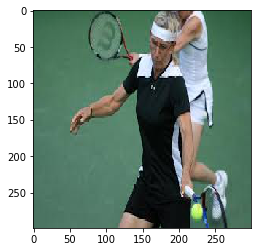

expected_class: female, predicts: [[ 0.46610364  0.53389639]]


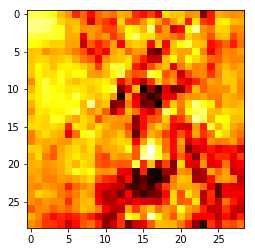

In [494]:
res= load_img_and_occuluding(model, './data/images/test/female/female_093.jpg', window_size=(10,10), correct_class=0 )

(299, 299, 3)


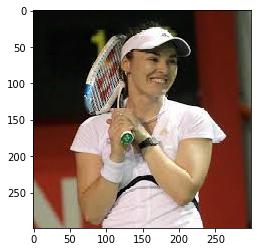

expected_class: female, predicts: [[ 0.73632479  0.26367521]]


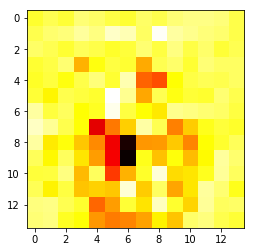

In [510]:
res= load_img_and_occuluding(model, './data/images/test/female/pic_146.jpg', window_size = (20,20), correct_class = 0)

(299, 299, 3)


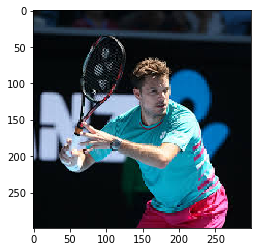

expected_class: male, predicts: [[ 0.45510235  0.54489768]]


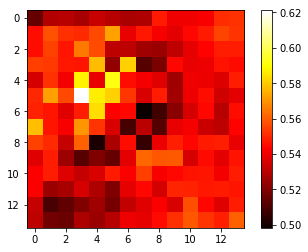

In [512]:
res= load_img_and_occuluding(model, './data/images/test/male/pic_150.jpg', window_size=(20,20), correct_class=1)

(299, 299, 3)


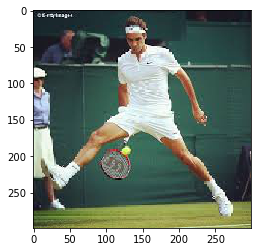

expected_class: male, predicts: [[ 0.37490031  0.62509972]]


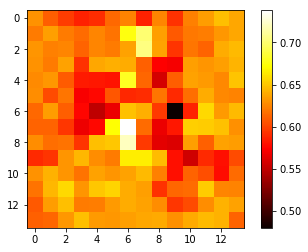

In [513]:
res= load_img_and_occuluding(model, './data/images/test/male/pic_152.jpg', window_size=(20,20), correct_class=1)

(299, 299, 3)


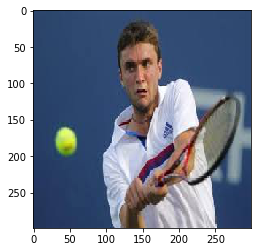

expected_class: male, predicts: [[ 0.29435432  0.70564568]]


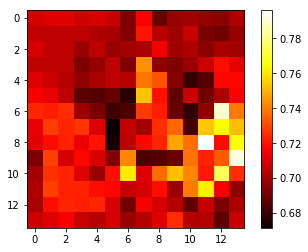

In [516]:
res= load_img_and_occuluding(model, './data/images/test/male/male_141.jpg', window_size=(20,20), correct_class=1)

(299, 299, 3)


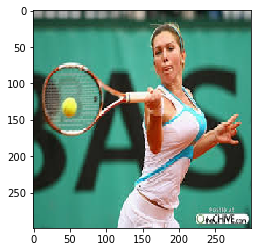

expected_class: female, predicts: [[ 0.90556771  0.09443226]]


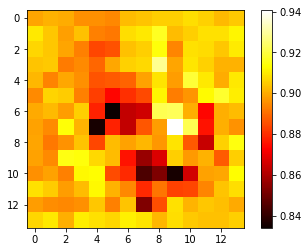

In [514]:
res= load_img_and_occuluding(model, './data/images/test/female/female_097.jpg', window_size=(20,20), correct_class=0 )

(299, 299, 3)


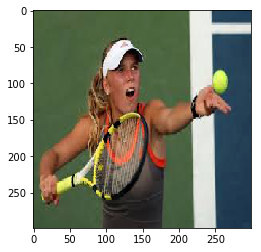

expected_class: female, predicts: [[ 0.43924347  0.5607565 ]]


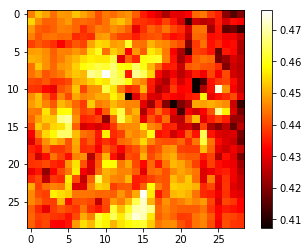

In [515]:
res= load_img_and_occuluding(model, './data/images/test/female/female_098.jpg', window_size=(10,10), correct_class=0 )

(299, 299, 3)


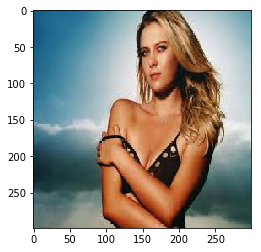

expected_class: female, predicts: [[ 0.96753192  0.03246813]]


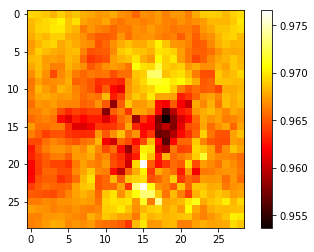

In [517]:
res= load_img_and_occuluding(model, './data/images/train/female/female_131.jpg', window_size=(10,10), correct_class=0 )

(299, 299, 3)


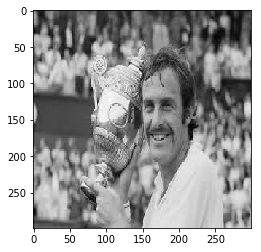

expected_class: male, predicts: [[ 0.4828473   0.51715273]]


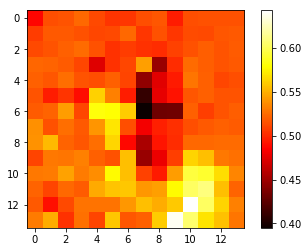

In [521]:
res= load_img_and_occuluding(model, './data/images/test/male/male_139.jpg', window_size=(20,20), correct_class=1 )